In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
import lightgbm as lgb
import warnings
import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
%%time
train_id = pd.read_csv('train_identity.csv')
train_tr = pd.read_csv('train_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
test_tr = pd.read_csv('test_transaction.csv')

CPU times: user 30.7 s, sys: 3.67 s, total: 34.4 s
Wall time: 54.1 s


In [3]:
print(train_id.info())
print(train_tr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

3# Downcasts types to reduce memory usage

In [4]:
# def downcast_dtype(df):
#     _start = df.memory_usage(deep=True).sum() / 1024 ** 2
#     float_cols = [c for c in df if df[c].dtype == 'float64']
#     int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
#     df[float_cols] = df[float_cols].astype(np.float32)
#     df[int_cols] = df[int_cols].astype(np.int16)
#     _end = df.memory_usage(deep=True).sum() / 1024 ** 2
#     saved = (_start - _end) / _start * 100
#     print(f"Save {saved:.2f}%")
#     return df

In [5]:
# train_id = downcast_dtype(train_id)
# train_tr = downcast_dtype(train_tr)
# test_id = downcast_dtype(test_id)
# test_tr = downcast_dtype(test_tr)

In [6]:
# print(train_id.info())
# print(train_tr.info())

# Merging the data

In [7]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [9]:
train = pd.merge(train_tr, train_id, how='left', 
                 on='TransactionID', left_index=True, 
                right_index=True)

In [10]:
test = pd.merge(test_tr, test_id, how='left',
               on='TransactionID', left_index=True,
               right_index=True)

In [11]:
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3134634.750,3282269.500,3429904.25,3.577539e+06
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.00,1.839600e+04
...,...,...,...,...,...,...,...,...
id_22,5169.0,1.600271e+01,6.897665e+00,10.000,14.000,14.000,14.00,4.400000e+01
id_24,4747.0,1.280093e+01,2.372447e+00,11.000,11.000,11.000,15.00,2.600000e+01
id_25,5132.0,3.296089e+02,9.746109e+01,100.000,321.000,321.000,371.00,5.480000e+02
id_26,5163.0,1.490703e+02,3.210199e+01,100.000,119.000,149.000,169.00,2.160000e+02


In [13]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,506691.0,3.916894e+06,1.462692e+05,3.663549e+06,3790221.5,3916894.00,4043566.5,4170239.0
TransactionDT,506691.0,2.692994e+07,4.756507e+06,1.840322e+07,22771540.5,27204658.00,31348560.5,34214345.0
TransactionAmt,506691.0,1.347256e+02,2.457798e+02,1.800000e-02,40.0,67.95,125.0,10270.0
card1,506691.0,9.957222e+03,4.884961e+03,1.001000e+03,6019.0,9803.00,14276.0,18397.0
card2,498037.0,3.637354e+02,1.586887e+02,1.000000e+02,207.0,369.00,512.0,600.0
...,...,...,...,...,...,...,...,...
id-22,5062.0,1.533682e+01,5.618032e+00,1.100000e+01,14.0,14.00,14.0,44.0
id-24,4740.0,1.316667e+01,3.222440e+00,1.000000e+01,11.0,11.00,15.0,26.0
id-25,5039.0,3.320431e+02,8.635668e+01,1.000000e+02,321.0,321.00,355.0,549.0
id-26,5047.0,1.527529e+02,3.191700e+01,1.000000e+02,137.0,147.00,182.0,216.0


In [14]:
target = train['isFraud']
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [15]:
def differentcolumns(traincols, testcols):
    for i in traincols:
        if i not in testcols:
            print(i)
differentcolumns(train.columns, test.columns)

isFraud
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [16]:
test = test.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-

In [17]:
differentcolumns(train.columns, test.columns)

isFraud


# Missing Values

In [18]:
train.isnull().sum().sum()

115523073

In [19]:
train.isnull().count()

TransactionID     590540
isFraud           590540
TransactionDT     590540
TransactionAmt    590540
ProductCD         590540
                   ...  
id_36             590540
id_37             590540
id_38             590540
DeviceType        590540
DeviceInfo        590540
Length: 434, dtype: int64

In [20]:
def getnulls(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'precent'])
    return missing_data

In [21]:
# Train Data Missing Values
missing_data_train = getnulls(train)
missing_data_train.head(350).T

,id_24,id_25,id_07,id_08,id_21,id_26,id_22,id_23,id_27,dist2,D7,id_18,D13,D14,D12,id_04,id_03,D6,id_33,id_10,D8,D9,id_09,id_30,id_32,id_34,id_14,V149,V153,V156,V154,V155,V157,V158,V161,V163,V147,V148,V162,V146,V138,V139,V140,V141,V142,V166,V164,V160,V159,V143,V144,V145,V152,V151,V150,V165,V339,V322,V338,V337,V336,V335,V334,V333,V332,V331,V330,V329,V328,V327,V326,V325,V324,V323,DeviceInfo,id_13,id_16,V237,V230,V267,V266,V265,V264,V263,V262,V261,V260,V228,V258,V257,V229,V254,V269,V253,V252,V231,V232,V249,V248,V247,V246,V233,V244,V243,V242,V241,V240,V268,V226,V218,V278,V217,V236,V219,V223,V224,V235,V277,V275,V274,V273,V225,V276,id_05,id_06,R_emaildomain,id_20,id_19,id_17,V202,V207,V204,V203,V214,V211,V212,V213,V215,V216,V199,V168,V191,V206,V187,V182,V183,V178,V196,V177,V176,V167,V186,V181,V179,V190,V205,V192,V193,V173,V172,V174,V171,V175,V197,V180,V201,V184,V185,V188,V189,V194,V198,V195,V200,V170,V208,V209,V210,V169,id_31,DeviceType,id_02,id_11,id_28,id_29,id_38,id_35,id_36,id_37,id_15,V272,V271,V270,V239,V220,V221,V222,V234,V238,V259,V227,V245,V250,V251,V255,V256,id_12,id_01,dist1,M5,M7,M8,M9,D5,M4,D2,V5,V1,V2,V3,V4,V6,D11,V7,V8,V9,V10,V11,M3,M2,M1,D3,M6,V42,V52,V51,V50,V48,V47,V46,V45,V44,V43,V49,V41,V40,V39,V38,V37,V36,V35,D4,P_emaildomain,V76,V77,V78,V79,V83,V80,V81,V82,V90,V94,V93,V92,V91,V89,V88,V87,V86,V75,V85,V84,D15,V71,V53,V54,V55,V56,V57,V58,V59,V60,V62,V72,V63,V64,V65,V66,V67,V68,V69,V74,V70,V61,V73,V18,V14,V27,V30,V26,V25,V24,V23,V22,V21,V20,V19,V31,V17,V16,V15,V13,V29,V12,V32,V33,V34,V28,D10,addr2,addr1,card2,card5,card4,card6,card3,V314,V313,V283,D1,V282,V288,V289,V315,V296,V300,V301,V281,V95,V96,V106,V114,V113,V112,V111,V110,V109,V108,V107
total,585793.000000,585408.00000,585385.000000,585385.000000,585381.000000,585377.000000,585371.000000,585371.000000,585371.000000,552913.000000,551623.000000,545427.000000,528588.000000,528353.000000,525823.00000,524216.000000,524216.000000,517353.000000,517251.000000,515614.000000,515614.000000,515614.000000,515614.000000,512975.000000,512954.000000,512735.000000,510496.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,471874.000000,463220.000000,461200.00000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,453675.000000,453675.000000,453249.000000,451279.00000,451222.000000,451171.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450721.000000,450721.000000,450721.000000,450721.000000,450721.000000,450721.000000,450721.0000

In [22]:
# Test Data Missing Values
missing_data_test = getnulls(test)
missing_data_test.head(350).T

,id_24,id_25,id_26,id_07,id_08,id_21,id_27,id_22,id_23,dist2,id_18,D7,id_04,id_03,D12,id_30,id_32,id_33,id_14,id_34,id_09,D9,id_10,D8,V153,V157,V154,V155,V156,V158,V148,V161,V162,V163,V149,V147,V146,V138,V139,V140,V141,V142,V166,V164,V160,V159,V143,V144,V145,V152,V165,V150,V151,V328,V327,V339,V338,V337,V336,V335,V334,V333,V332,V331,V330,V322,V323,V324,V325,V329,V326,DeviceInfo,D14,D13,D6,id_16,V257,V268,V277,V276,V275,V274,V273,V247,V248,V249,V269,V265,V267,V266,V246,V264,V263,V262,V261,V260,V252,V258,V278,V242,V244,V243,V217,V218,V219,V223,V224,V225,V226,V228,V229,V230,V231,V232,V233,V235,V236,V237,V240,V241,V254,V253,id_13,id_05,id_06,id_20,R_emaildomain,id_19,id_17,V189,V195,V188,V170,V169,V197,V175,V198,V200,V201,V210,V209,V174,V171,V208,V180,V185,V194,V184,id_31,V199,V206,V187,V205,V204,V203,V202,V190,V191,V186,V176,V192,V181,V167,V196,V168,V179,V178,V177,V172,V173,V193,V182,V183,V207,V212,V213,V214,V215,V216,V211,id_11,id_28,id_29,DeviceType,id_02,id_35,id_15,id_37,id_36,id_38,V255,V234,V256,V238,V239,V222,V245,V250,V251,V221,V220,V272,V271,V270,V259,V227,id_01,id_12,M5,dist1,M4,M7,M8,M9,D2,D5,D3,M3,M1,M2,V1,V2,V5,V6,V7,D11,V11,V10,V9,V3,V4,V8,M6,V40,V41,V42,V45,V44,V52,V51,V50,V49,V48,V47,V46,V43,V39,V38,V37,V36,V35,D4,P_emaildomain,addr1,addr2,V60,V69,V74,V73,V72,V71,V70,V67,V68,V66,V57,V64,V63,V62,V61,V65,V58,V56,V54,V53,V59,V55,V12,V29,V19,V21,V22,V13,V23,V20,V24,V25,V26,V27,V28,V30,V31,V32,V33,V34,V18,V17,V16,V15,V14,D10,V76,V75,V81,V77,V88,V94,V93,V92,V91,V90,V89,V87,V78,V86,V85,V84,V82,V80,V79,V83,D15,card2,D1,V301,V300,V296,V289,V288,V283,V282,V281,V314,V315,V313,C13,card5,card4,card6,card3,C2,C9,V292,V291,V290,C10,V286,V287,V294,V285
total,501951.000000,501652.000000,501644.000000,501632.000000,501632.000000,501632.000000,501629.00000,501629.00000,501629.00000,470255.00000,455816.000000,446558.000000,440210.000000,440210.000000,437437.000000,436032.000000,436020.000000,436020.000000,435334.000000,434516.000000,432353.000000,432353.000000,432353.000000,432353.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,391634.000000,391497.000000,383307.000000,381908.00000,380944.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,376405.000000,371941.000000,371941.000000,371058.000000,370821.000000,370785.000000,370725.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370066.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.000000,369957.00000

In [23]:
# Get the columns that we have to drop
droppedcols = missing_data_train[missing_data_train['total'] > 100000].index
droppedcols

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2',
       ...
       'V43', 'V49', 'V41', 'V40', 'V39', 'V38', 'V37', 'V36', 'V35', 'D4'],
      dtype='object', length=252)

In [24]:
# Drop the columns
train.drop(droppedcols, axis=1, inplace=True)
test.drop(droppedcols, axis=1, inplace=True)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 182 entries, TransactionID to V321
dtypes: float64(174), int64(4), object(4)
memory usage: 820.0+ MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 181 entries, TransactionID to V321
dtypes: float64(174), int64(3), object(4)
memory usage: 699.7+ MB


In [27]:
print(train.shape)
print(test.shape)

(590540, 182)
(506691, 181)


In [28]:
missing_data_train = getnulls(train)
missing_data_train.head(200).T

,P_emaildomain,V89,V75,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V90,V91,V92,V93,V76,V94,D15,V69,V70,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V74,V73,V72,V71,V31,V32,V34,V33,V16,V14,V29,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V30,V13,V12,D10,addr2,addr1,card2,card5,card4,card6,card3,V315,V281,V282,V283,V314,V288,V289,V301,V313,D1,V296,V300,V131,V132,V137,V136,V135,V114,V133,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V113,V112,V111,V101,V134,V95,V96,V97,V98,V99,V100,V102,V110,V103,V104,V105,V106,V107,V108,V109,V115,V321,V320,V302,V311,V312,V316,V317,V318,V319,V279,V308,V307,V306,V305,V309,V303,V304,V299,V291,V280,V284,V285,V286,V287,V290,V298,V310,V292,V293,V294,V295,V297,TransactionDT,ProductCD,card1,isFraud,TransactionAmt,C12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C13,C14,TransactionID
total,94456.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89113.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76022.000000,65706.000000,65706.000000,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.159949,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150901,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128733,0.111264,0.111264,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,

In [29]:
missing_data_test = getnulls(test)
missing_data_test.head(200).T

,P_emaildomain,addr2,addr1,V71,V70,V69,V68,V67,V66,V65,V58,V63,V64,V73,V62,V61,V60,V59,V53,V54,V55,V56,V72,V57,V74,V16,V18,V20,V21,V22,V23,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V17,V19,V15,V14,V12,V13,V24,D10,V88,V94,V81,V82,V83,V84,V76,V77,V93,V87,V92,V86,V78,V89,V75,V85,V91,V90,V79,V80,D15,card2,V282,V296,V315,V314,V313,V283,V281,V300,V301,V288,V289,D1,C13,card5,card4,card6,card3,C10,C1,C14,C2,C9,C3,C4,C5,C6,C12,C11,C8,C7,V321,V320,V304,V299,V298,V297,V295,V294,V293,V292,V291,V290,V287,V286,V285,V284,V280,V279,V302,V303,V317,V306,V307,V308,V309,V310,V311,V312,V316,V305,V318,V319,TransactionDT,V136,V137,V134,TransactionAmt,ProductCD,card1,V135,V133,V95,V104,V111,V110,V109,V108,V107,V106,V105,V103,V113,V102,V101,V100,V99,V98,V97,V96,V112,V114,V132,V124,V131,V130,V129,V128,V127,V126,V125,V123,V115,V122,V121,V120,V119,V118,V117,V116,TransactionID
total,69192.000000,65609.000000,65609.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12545.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12069.000000,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.136557,0.129485,0.129485,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024759,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023819,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train['P_emaildomain']

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: P_emaildomain, Length: 590540, dtype: object

In [31]:
train['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
twc.com                230
n

# See if there is some pattern in this column or just it's useless and get rid of it

In [32]:
target.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [33]:
cntgmail = 0
cntyahoo = 0
cnthotmail = 0
cntanon = 0
cntaol = 0
for i in range(train.shape[0]):
    if train['P_emaildomain'][i] == 'gmail.com' and train['isFraud'][i] == 1:
        cntgmail += 1
    elif train['P_emaildomain'][i] == 'yahoo.com' and train['isFraud'][i] == 1:
        cntyahoo += 1
    elif train['P_emaildomain'][i] == 'hotmail.com' and train['isFraud'][i] == 1:
        cnthotmail += 1
    elif train['P_emaildomain'][i] == 'anonymous.com' and train['isFraud'][i] == 1:
        cntanon += 1
    elif train['P_emaildomain'][i] == 'aol.com' and train['isFraud'][i] == 1:
        cntaol += 1
    
print("GMAIL:", cntgmail)
print("YAHOO:", cntyahoo)
print("HOTMAIL:", cnthotmail)
print("ANON:", cntanon)
print("AOL:", cntaol)

GMAIL: 9943
YAHOO: 2297
HOTMAIL: 2396
ANON: 859
AOL: 617


# There is no specific pattern in this columns if there is some specific domain is always fraud or something.
# So it's time to get rid of it i guess.

In [34]:
train.drop(['P_emaildomain'], axis=1, inplace=True)
test.drop(['P_emaildomain'], axis=1, inplace=True)

In [35]:
print(train.shape)
print(test.shape)

(590540, 181)
(506691, 180)


In [36]:
missing_data_train = getnulls(train)
missing_data_train.head(100).T

,V90,V84,V77,V78,V79,V80,V81,V82,V83,V85,V75,V86,V87,V88,V89,V91,V92,V93,V76,V94,D15,V70,V62,V53,V54,V55,V56,V57,V58,V59,V60,V61,V63,V71,V64,V65,V66,V67,V68,V69,V74,V73,V72,V32,V33,V34,V30,V15,V25,V24,V23,V22,V21,V20,V27,V19,V18,V17,V31,V28,V16,V14,V13,V12,V29,V26,D10,addr2,addr1,card2,card5,card4,card6,card3,V288,V283,V282,V281,V300,V289,V296,V301,D1,V313,V314,V315,V134,V137,V133,V114,V135,V117,V118,V119,V120,V121,V122,V123,V124,V125
total,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89113.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76022.000000,65706.000000,65706.000000,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
precent,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150901,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128733,0.111264,0.111264,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532


In [37]:
missing_data_test = getnulls(test)
missing_data_test.head(100).T

,addr2,addr1,V63,V71,V70,V69,V68,V67,V66,V65,V58,V64,V73,V62,V61,V60,V59,V53,V54,V55,V56,V72,V57,V74,V16,V18,V20,V21,V22,V23,V24,V26,V27,V28,V29,V30,V31,V32,V33,V34,V17,V19,V25,V15,V14,V13,V12,D10,V94,V82,V83,V84,V85,V76,V77,V78,V87,V93,V88,V91,V79,V86,V89,V75,V92,V90,V80,V81,D15,card2,V282,V283,V288,V289,D1,V313,V296,V314,V315,V300,V301,V281,C13,card5,card4,card6,card3,C2,C1,C7,C3,C4,C5,C6,C9,C10,C11,C12,C14,C8
total,65609.000000,65609.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12545.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12069.000000,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
precent,0.129485,0.129485,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024759,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023819,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


In [38]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,111.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0

# We can not figure out some pattern in this floating number columns cuz it has no meaning for us, so let's get rid of some of them and replace the nulls at others.

In [39]:
droppedcols = missing_data_train[missing_data_train['total'] > 15000].index

In [40]:
train.drop(droppedcols, axis=1, inplace=True)
test.drop(droppedcols, axis=1, inplace=True)
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 111)


In [41]:
differentcolumns(train.columns, test.columns)

isFraud


In [42]:
missing_data_train = getnulls(train)
missing_data_train.head(100).T

,card2,card5,card4,card6,card3,V283,V282,V300,V301,V289,V288,V281,D1,V313,V314,V315,V296,V133,V117,V118,V137,V136,V135,V134,V124,V132,V131,V130,V116,V128,V127,V126,V125,V119,V123,V122,V129,V111,V115,V114,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V120,V112,V113,V121,V321,V320,V302,V319,V318,V317,V316,V312,V279,V310,V309,V308,V307,V306,V305,V304,V303,V311,V299,V280,V297,V295,V294,V293,V292,V291,V290,V287,V286,V298,V285,V284,TransactionDT,card1,ProductCD,TransactionAmt,C2,isFraud,C1,C6
total,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
missing_data_test = getnulls(test)
missing_data_test.head(100).T

,card2,V283,V314,V296,V300,V289,V313,V281,V315,V288,V282,D1,V301,C13,card5,card4,card6,card3,V280,V279,C1,C3,C2,V285,V320,C4,C5,C6,C7,C8,C9,C10,C11,C12,C14,V284,V321,V286,V302,V319,V318,V317,V316,V312,V311,V310,V309,V308,V307,V306,V304,V303,V305,V299,V293,V287,V290,V291,V298,V292,V294,V295,V297,card1,ProductCD,TransactionAmt,TransactionDT,V103,V95,V96,V97,V98,V99,V100,V101,V102,V125,V104,V130,V123,V124,V126,V127,V128,V129,V131,V105,V132,V133,V134,V135,V136,V137,V122,V121,V120,V119,V118,V117,V116
total,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Concatinating all data to fill the null values with the mean and mode

In [44]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0, sort=False)
all_data.shape

(1097231, 112)

In [45]:
ntrain + ntest

1097231

In [46]:
all_data_cols = all_data.columns
for i in all_data_cols:
    if all_data[i].dtype == 'object':
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [47]:
missing_data = getnulls(all_data)
missing_data.head(110).T

,isFraud,card2,card5,V283,D1,V300,V301,V289,V288,V282,V281,V313,V314,V315,V296,C13,card3,V133,V117,V118,V137,V136,V135,V134,V124,V132,V131,V130,V116,V128,V127,V126,V125,V119,V123,V122,V129,V111,V115,V114,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V120,V112,V113,V121,V321,V320,V302,V319,V318,V317,V316,V312,V279,V310,V309,V308,V307,V306,V305,V304,V303,V311,V299,V291,V286,V285,V284,V287,V290,V280,V292,V293,V294,V295,V297,V298,C4,C1,C2,C3,C6,C5,C7,C8,C9,C10,C11,C12,C14,card6,card4,card1,ProductCD,TransactionAmt
total,506691.000000,17587.000000,8806.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,4748.000000,4567.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.016029,0.008026,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.004327,0.004162,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.0,0.0,0.0,0.0,0.0


In [48]:
all_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
for i in all_data_cols:
    if (i.startswith("C") or (i.startswith("V"))) and all_data[i].isnull().sum() > 0:
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])
missing_data = getnulls(all_data)
missing_data.head(10).T

,isFraud,card2,card5,D1,card3,V109,V108,V107,V106,V105
total,506691.000000,17587.000000,8806.000000,7300.000000,4567.000000,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.016029,0.008026,0.006653,0.004162,0.0,0.0,0.0,0.0,0.0


In [50]:
all_data['card3'].value_counts()

150.0    956845
185.0    109960
106.0      3543
117.0      2841
144.0      2633
          ...  
172.0         1
221.0         1
178.0         1
139.0         1
232.0         1
Name: card3, Length: 133, dtype: int64

In [51]:
all_data['D1'].value_counts()

0.0      507854
1.0       16887
2.0        9974
3.0        8038
4.0        6965
          ...  
557.0       278
593.0       276
591.0       273
640.0        67
641.0         1
Name: D1, Length: 642, dtype: int64

In [52]:
all_data['D1'] = all_data['D1'].fillna(all_data['D1'].mode()[0])

In [53]:
all_data['card3'] = all_data['card3'].fillna(all_data['card3'].mean())

In [54]:
all_data['card2'].value_counts()

321.0    91731
111.0    82537
555.0    80404
490.0    70496
583.0    41503
         ...  
293.0      126
419.0      126
121.0      126
552.0      125
487.0      123
Name: card2, Length: 501, dtype: int64

In [55]:
all_data['card2'] = all_data['card2'].fillna(all_data['card2'].mean())

In [56]:
missing_data = getnulls(all_data)
missing_data.head(5).T

,isFraud,card5,V321,V110,V99
total,506691.000000,8806.000000,0.0,0.0,0.0
precent,0.461791,0.008026,0.0,0.0,0.0


In [57]:
all_data['card5'].value_counts()

226.0    553537
224.0    153109
166.0    102930
102.0     49491
117.0     47061
          ...  
221.0         1
175.0         1
208.0         1
124.0         1
209.0         1
Name: card5, Length: 138, dtype: int64

In [58]:
all_data['card5'] = all_data['card5'].fillna(all_data['card5'].mean())

In [59]:
missing_data = getnulls(all_data)
missing_data.head(5).T

,isFraud,V321,V110,V99,V100
total,506691.000000,0.0,0.0,0.0,0.0
precent,0.461791,0.0,0.0,0.0,0.0


# All the null values have been handled

In [60]:
print(ntrain)
print(ntest)
print(ntrain+ntest)
print(all_data.shape)

590540
506691
1097231
(1097231, 112)


In [61]:
# Split the data again
train = all_data[:ntrain]
test = all_data[ntrain:]

In [62]:
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 112)


In [63]:
test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,NaN,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,NaN,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,NaN,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,NaN,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,NaN,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,1.0,3.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
print(test['isFraud'].value_counts())
test.drop(['isFraud'], axis=1, inplace=True)

Series([], Name: isFraud, dtype: int64)


In [65]:
print(test.shape)

(506691, 111)


# Correlations

<AxesSubplot:>

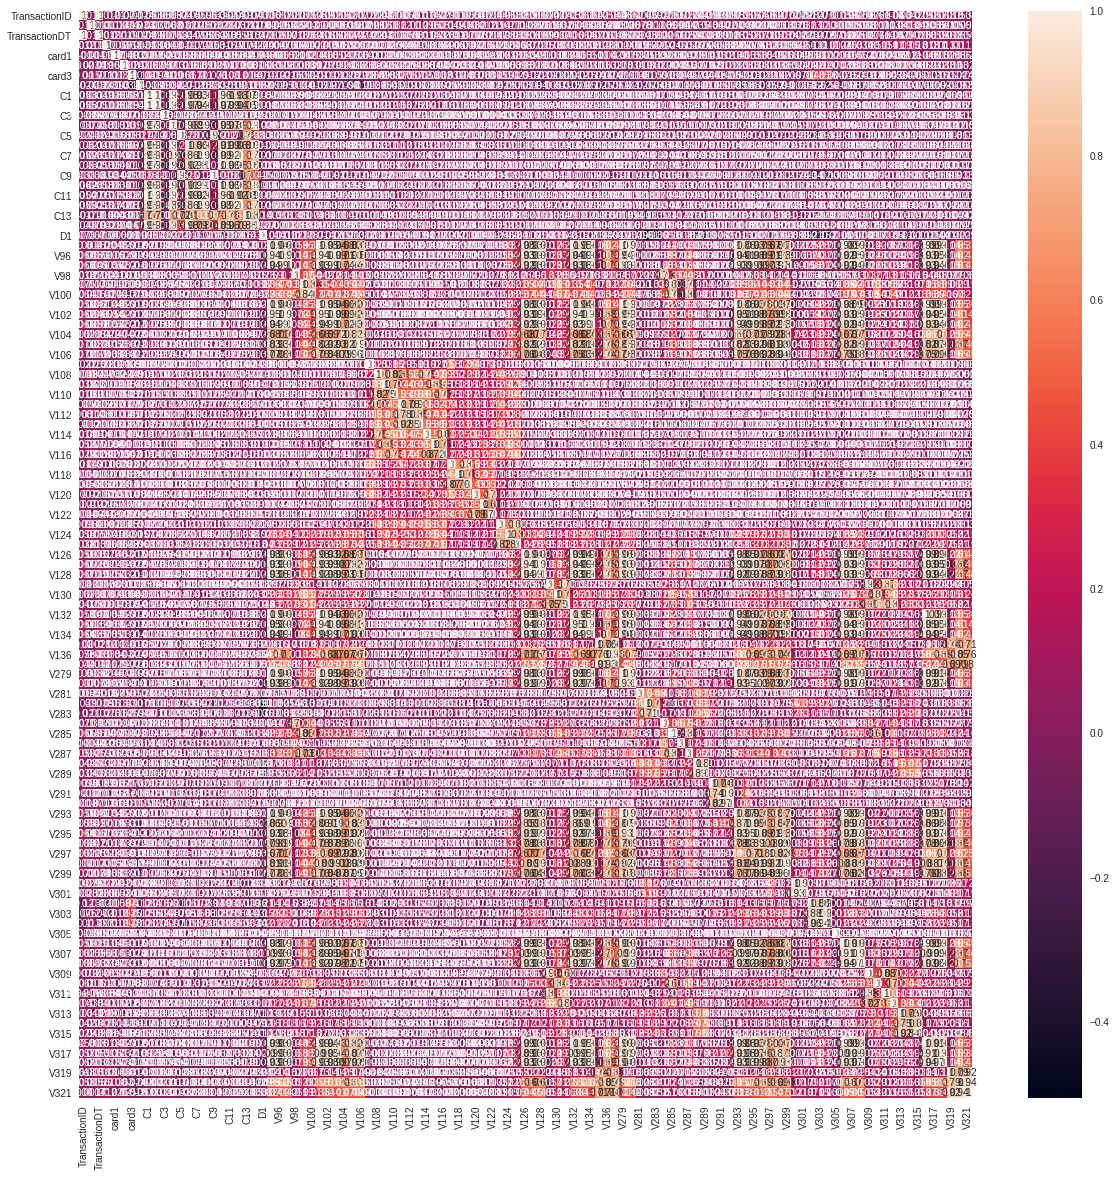

In [66]:
corr = train.corr()
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=True)

# Okay this is just terrifing, we gotta figure some way to visualize it.

In [67]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0.0,86400,68.5,W,13926,363.099769,150.0,discover,142.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0.0,86401,29.0,W,2755,404.000000,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0.0,86469,59.0,W,4663,490.000000,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0.0,86499,50.0,W,18132,567.000000,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0.0,86506,50.0,H,4497,514.000000,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

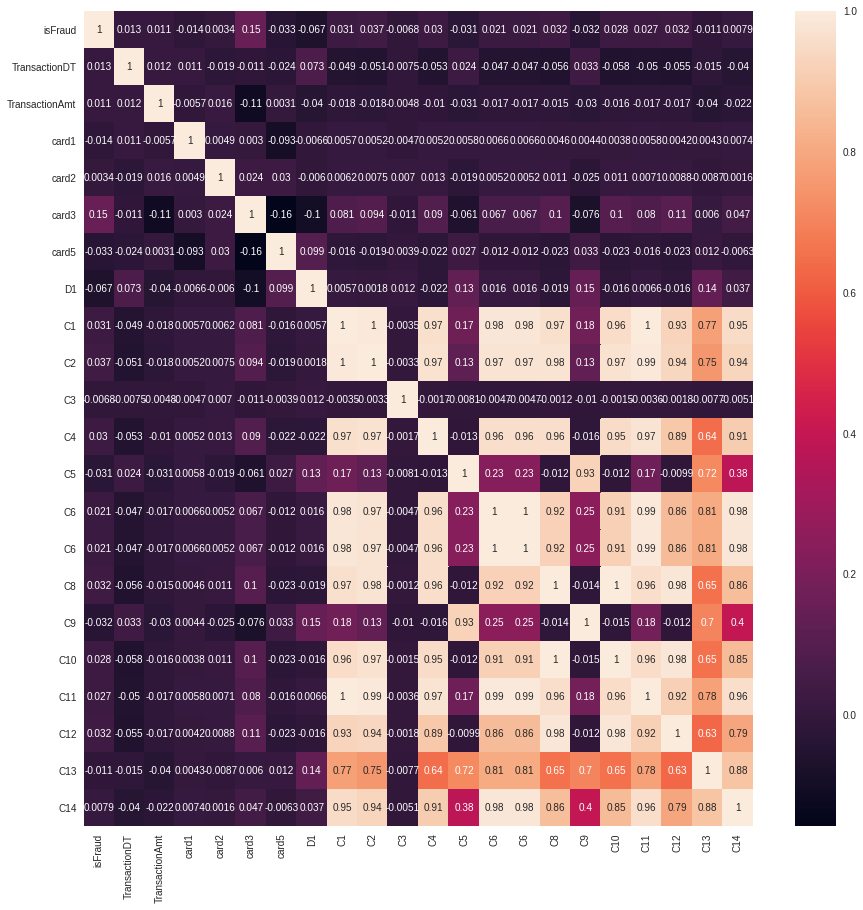

In [68]:
templst = ['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 
           'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'D1', 
           'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C6', 'C8', 'C9', 'C10', 
           'C11', 'C12', 'C13', 'C14']
corr1 = train[templst].corr()
plt.subplots(figsize=(15, 15))
sns.heatmap(corr1, annot=True)

# Hmmmmm It seems like there is no features have a strong correlation with the target feature, so we gotta keep as much feature as we can to take over that
# We are not going to delete more features

# Concatinating the data again to encode the categorical features

In [69]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0, sort=False)
print(all_data.shape)

(1097231, 112)


In [70]:
ntrain + ntest

1097231

In [71]:
# Encoding the data
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head()

(1097231, 122)


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000,0.0,86400,68.5,13926,363.099769,150.0,142.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,2987001,0.0,86401,29.0,2755,404.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,2987002,0.0,86469,59.0,4663,490.000000,150.0,166.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,2987003,0.0,86499,50.0,18132,567.000000,150.0,117.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,2987004,0.0,86506,50.0,4497,514.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [72]:
# Split the data again and get ready for training
train = all_data[:ntrain]
test = all_data[ntrain:]
train.drop(['TransactionID'], axis=1, inplace=True)
test_id = test['TransactionID']
test.drop(['TransactionID'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(590540, 121)
(506691, 121)


In [73]:
train.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,0.0,86400,68.5,13926,363.099769,150.0,142.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,0.0,86401,29.0,2755,404.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,0.0,86469,59.0,4663,490.000000,150.0,166.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,0.0,86499,50.0,18132,567.000000,150.0,117.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,0.0,86506,50.0,4497,514.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [74]:
test.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,NaN,18403224,31.95,10409,111.0,150.0,226.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,NaN,18403263,49.00,4272,111.0,150.0,226.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,NaN,18403310,171.00,4476,574.0,150.0,226.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,NaN,18403310,284.95,10989,360.0,150.0,166.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,NaN,18403317,67.95,18018,452.0,150.0,117.0,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,1.0,3.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [75]:
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [76]:
differentcolumns(train.columns, test.columns)

In [77]:
train.drop(['isFraud'], axis=1, inplace=True)
test.drop(['isFraud'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(590540, 120)
(506691, 120)


# Modelling

In [78]:
# XGBOOST
xgmodel = xgb.XGBClassifier(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=50, 
                             min_child_weight=1.7817, n_estimators=200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
xgmodel.fit(train, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=50,
              min_child_weight=1.7817, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
              scale_pos_weight=1, subsample=0.5213, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [80]:
y_pred_xg = xgmodel.predict_proba(test)

In [81]:
y_pred_xg

array([[0.99739   , 0.00261001],
       [0.99523836, 0.00476162],
       [0.9930563 , 0.00694372],
       ...,
       [0.9811421 , 0.01885792],
       [0.99194276, 0.00805723],
       [0.9963382 , 0.00366183]], dtype=float32)

In [82]:
y_pred_xg.shape

(506691, 2)

In [86]:
y_pred_xg[:, 1]

array([0.00261001, 0.00476162, 0.00694372, ..., 0.01885792, 0.00805723,
       0.00366183], dtype=float32)

In [87]:
sub = pd.DataFrame()
sub['TransactionID'] = test_id
sub['isFraud'] = y_pred_xg[:, 1]
sub.to_csv('submission_xgb.csv', index=False)

In [84]:
# Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=30)

In [85]:
rf.fit(train, target)

RandomForestClassifier(max_depth=30, n_estimators=150)

In [90]:
y_pred_rf = rf.predict_proba(test)

In [91]:
y_pred_rf[:, 1]

array([0.01568259, 0.03083724, 0.04423253, ..., 0.0295106 , 0.04617113,
       0.01963112])

In [92]:
sub_rf = pd.DataFrame()
sub_rf['TransactionID'] = test_id
sub_rf['isFraud'] = y_pred_rf[:, 1]
sub_rf.to_csv('submission_rf.csv', index=False)